In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy.sparse import csr_matrix, hstack
from scipy import sparse
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
import pickle
import seaborn as sns
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from datetime import datetime
import tzlocal
from textblob import TextBlob
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string


dataset = pd.read_csv("./data/train.csv")

    Create weighted avg product score; review length; user avg score

In [750]:
# Create weighted usefulness according to alpha-beta prior

deno = dataset.HelpfulnessDenominator.sum()/dataset.HelpfulnessDenominator.count()
numer = dataset.HelpfulnessNumerator.sum()/dataset.HelpfulnessNumerator.count()

In [754]:
#fill null value
dataset['HelpfulnessNumerator'].fillna(numer,inplace = True)
dataset['HelpfulnessDenominator'].fillna(deno, inplace = True)

# set up alpha and Beta's value

dataset['weighted_num'] = dataset['HelpfulnessNumerator']+numer
dataset['weighted_usefulness'] = dataset['weighted_num']/(dataset['HelpfulnessDenominator']+deno)
dataset['weighted_score'] = dataset['Score'] * dataset['weighted_usefulness']

In [767]:
dataset['help_ratio'] = dataset['HelpfulnessNumerator']/dataset['HelpfulnessDenominator']
dataset['help_ratio'].fillna(numer/deno, inplace=True)

In [651]:
# create dictionary avg_score for weighted average score of each product
temp = dataset.dropna(subset=['Score'])
avg_score = {}
for p in temp['ProductId'].unique():
    avg_score[p] = (temp[temp['ProductId']==p]['weighted_score'].sum())/(temp[temp['ProductId']==p]['weighted_usefulness'].sum())


In [653]:
# insert the column in both X_train (to plot) and dataset (for later testing)

default_avg_score = sum(avg_score.values())/len(avg_score.values())
# X_train['Weight_avg_score'] = X_train.apply(lambda row : avg_score.get(row['ProductId']) 
#                                             if (row['ProductId'] in avg_score) else default_avg_score, axis = 1)
dataset['Weight_avg_score'] = dataset.apply(lambda row : avg_score.get(row['ProductId']) 
                                            if (row['ProductId'] in avg_score) else default_avg_score, axis = 1)

In [662]:
temp = dataset.dropna(subset=['Score'])
avg_product_score = {}
for p in temp['ProductId'].unique():
    avg_product_score[p] = (temp[temp['ProductId']==p]['Score'].sum())/(temp[temp['ProductId']==p]['Score'].count())

In [663]:
# insert the column in dataset
default_score = sum(avg_product_score.values())/len(avg_product_score.values())
dataset['avg_product_score'] = dataset.apply(lambda row : avg_product_score.get(row['ProductId']) 
                                            if (row['ProductId'] in avg_product_score) else default_score, axis = 1)

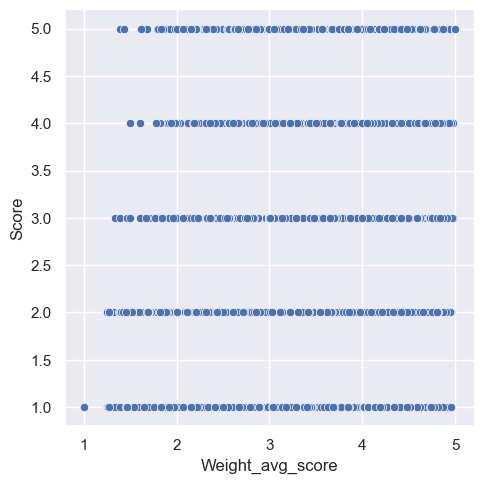

In [13]:
sns.set_theme(style="darkgrid")
sns.relplot(data=X_train, x="Weight_avg_score", y="Score")

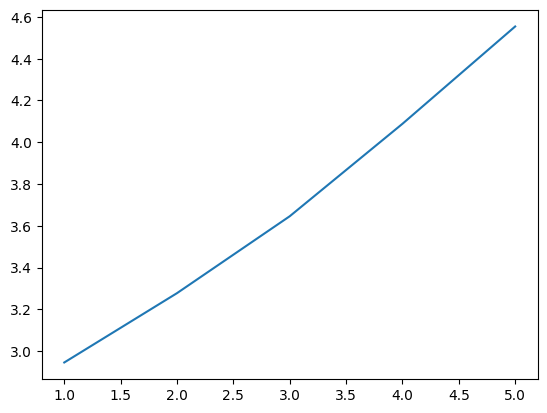

In [ ]:
# plot relation btw score and avg-score

y = [X_train[Y_train== float(i)]['Weight_avg_score'].values.mean() for i in range(1,6)]
x = [i for i in range(1,6)]
plt.plot(x,y)
plt.show()

average score works but no sure if work individually

In [87]:
dataset['ReviewLength'] = dataset.apply(lambda row : len(row['Text'].split()) if type(row['Text']) == str else 0, axis = 1)
dataset['weighted_review_length'] = dataset['ReviewLength']* dataset['weighted_usefulness']

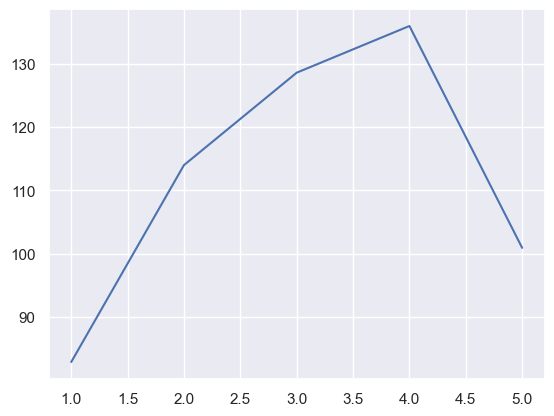

In [88]:
y = [X_train[Y_train== float(i)]['weighted_review_length'].values.mean() for i in range(1,6)]
x = [i for i in range(1,6)]
plt.plot(x,y)
plt.show()

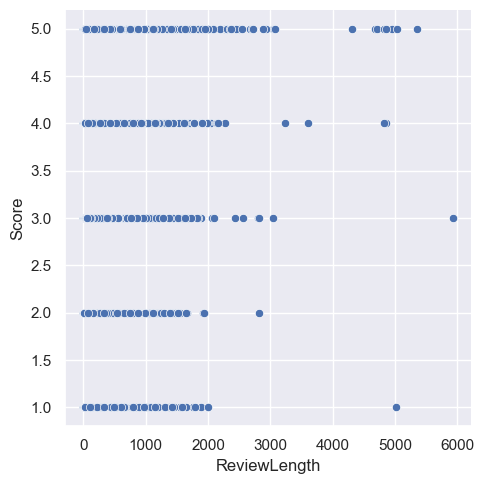

In [112]:
sns.set_theme(style="darkgrid")
sns.relplot(data=X_train, x="ReviewLength", y="Score")

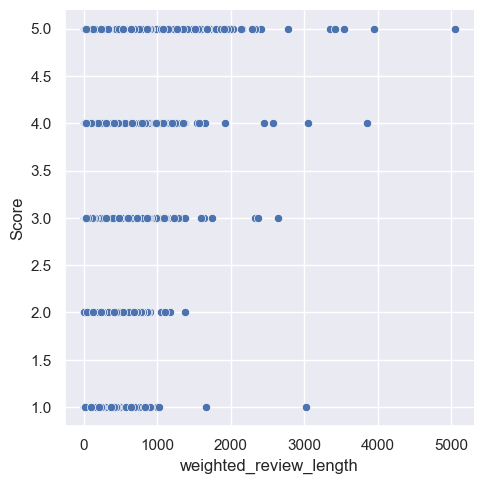

In [159]:
# fix some outlier with weighted, but need further processing
sns.set_theme(style="darkgrid")
sns.relplot(data=X_train, x="weighted_review_length", y="Score")

clean outliers

In [94]:
def clean_outlier(X, Y_train,col):
    temp = X.copy()
    for s in range(1,6):
        Q1 = np.percentile(temp[Y_train == s][col], 1,
                    interpolation = 'midpoint')
        Q3 = np.percentile(temp[Y_train == s][col], 99,
                        interpolation = 'midpoint')
        IQR = Q3 - Q1
        
        # Upper bound
        upper=Q3+1.5*IQR
        median = temp[Y_train == s][col].median()
        # Lower bound
        lower=Q1-1.5*IQR
        # Removing the outliers
        temp[col] = np.where(
        (Y_train == s) & (temp[col] >= upper) , median, temp[col]
        )
        temp[col] = np.where(
        (Y_train == s) & (temp[col] <= lower) , median, temp[col]
        )
    return temp

/var/folders/jc/ytj5cn2153v5xcrd3vd8mj600000gn/T/ipykernel_1567/670054060.py:4: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = np.percentile(temp[Y_train == s][col], 1,
/var/folders/jc/ytj5cn2153v5xcrd3vd8mj600000gn/T/ipykernel_1567/670054060.py:6: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3 = np.percentile(temp[Y_train == s][col], 99,
/var/folders/jc/ytj5cn2153v5xcrd3vd8mj600000gn/T/ipykernel_1567/670054060.py:4: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lo

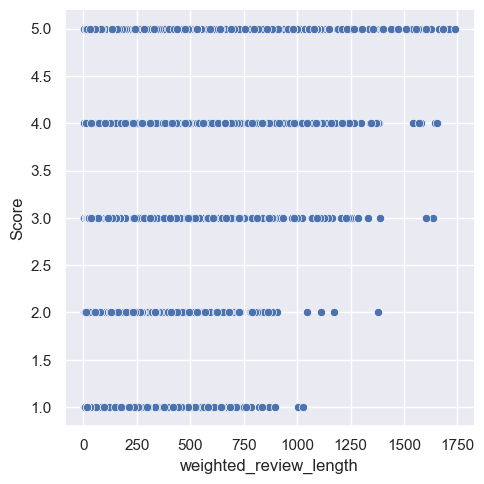

In [175]:
temp = clean_outlier(X_train, Y_train,'weighted_review_length')
sns.set_theme(style="darkgrid")
sns.relplot(data=temp, x="weighted_review_length", y="Score")
dataset = clean_outlier(dataset, dataset['Score'],'weighted_review_length')

In [126]:
# create dictionary user_avg_score for weighted average score of each product
# Find relation btw user and the score they give
#TODO: can change to train on dataset
temp = dataset.dropna(subset=['Score'])
user_avg_score = {}
for p in temp['UserId'].unique():
    user_avg_score[p] = (temp[temp['UserId']==p]['Score'].sum())/temp[temp['UserId']==p].shape[0]

In [127]:
# insert the column in both X_train (to plot) and dataset (for later testing)

default_user_avg_score = sum(user_avg_score.values())/len(user_avg_score.values())
dataset['user_avg_score'] = dataset.apply(lambda row : user_avg_score.get(row['UserId']) 
                                            if (row['UserId'] in user_avg_score) else default_user_avg_score, axis = 1)

In [399]:
# plot relation btw score and usr-avg-score

y = [X_train[Y_train== float(i)]['user_avg_score'].values.mean() for i in range(1,6)]
x = [i for i in range(1,6)]
plt.plot(x,y)
plt.show()

IndexError: Index dimension must be 1 or 2

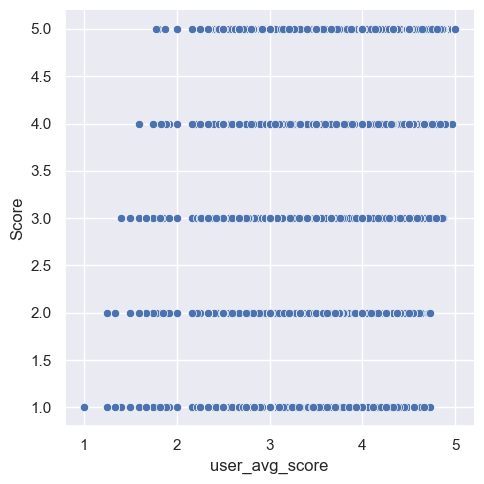

In [183]:
sns.set_theme(style="darkgrid")
sns.relplot(data=X_train, x="user_avg_score", y="Score")

/var/folders/jc/ytj5cn2153v5xcrd3vd8mj600000gn/T/ipykernel_1567/670054060.py:4: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = np.percentile(temp[Y_train == s][col], 1,
/var/folders/jc/ytj5cn2153v5xcrd3vd8mj600000gn/T/ipykernel_1567/670054060.py:6: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3 = np.percentile(temp[Y_train == s][col], 99,
/var/folders/jc/ytj5cn2153v5xcrd3vd8mj600000gn/T/ipykernel_1567/670054060.py:4: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lo

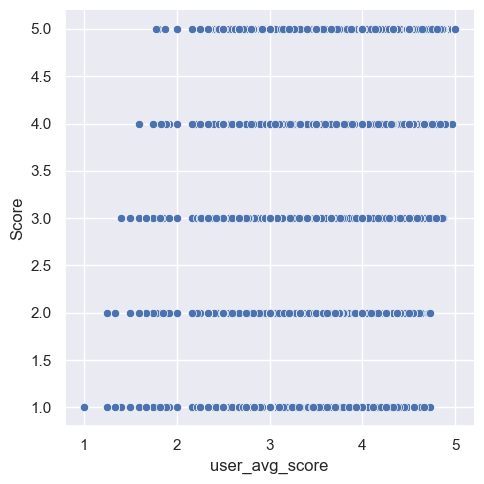

In [186]:
temp = clean_outlier(X_train, Y_train,'user_avg_score')
sns.set_theme(style="darkgrid")
sns.relplot(data=temp, x="user_avg_score", y="Score")
dataset = clean_outlier(dataset, dataset['Score'],'user_avg_score')

So the user avg score does has effect on score

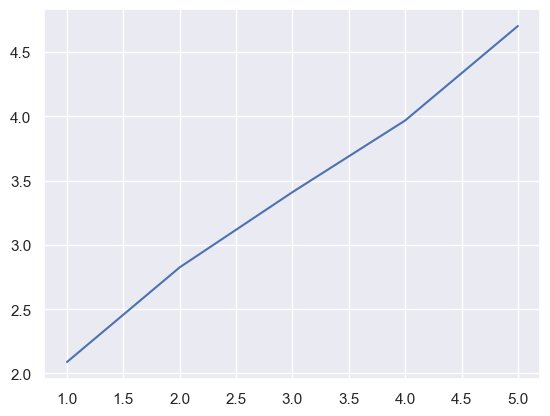

In [187]:
# relation between reviewlength and score
y = [X_train[Y_train == float(i)]['user_avg_score'].values.mean() for i in range(1,6)]
x = [i for i in range(1,6)]
plt.plot(x,y)
plt.show()

    Process Time https://www.geeksforgeeks.org/how-to-convert-timestamp-string-to-datetime-object-in-python/

In [964]:
from datetime import datetime

dataset['year'] = dataset['Time'].apply(lambda x: datetime.fromtimestamp(x).year) 
dataset['month'] = dataset['Time'].apply(lambda x: datetime.fromtimestamp(x).month) 
dataset['day'] = dataset['Time'].apply(lambda x: datetime.fromtimestamp(x).day)
dataset['hour'] = dataset['Time'].apply(lambda x: datetime.fromtimestamp(x).hour)

    Analyze Sentiment/Topic in Review

Clean the text first

In [448]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Define a function to clean the text
def clean_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Join the tokens back into a string
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text
# clean_text("I don't like this movie actutally. It has suck plot. But the actor is pretty.")

[nltk_data] Downloading package punkt to /Users/joleneyu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joleneyu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/joleneyu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [449]:
dataset['Text'].loc[dataset['Text'].isna()] = ''
dataset['Summary'].loc[dataset['Summary'].isna()] = ''
dataset['Cleanedtext'] = dataset['Text'].apply(clean_text)
dataset['Cleanedsummary'] = dataset['Summary'].apply(clean_text)

/var/folders/jc/ytj5cn2153v5xcrd3vd8mj600000gn/T/ipykernel_1567/1004469559.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Text'].loc[dataset['Text'].isna()] = ''
/var/folders/jc/ytj5cn2153v5xcrd3vd8mj600000gn/T/ipykernel_1567/1004469559.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Summary'].loc[dataset['Summary'].isna()] = ''


Analyze the topic

In [26]:
import pyLDAvis.gensim_models
import gensim
# Create a dictionary and corpus from the 'Review' column
# text part
text_list = dataset['Cleanedtext'].tolist()
texts = [text.split() for text in text_list]
text_dictionary = gensim.corpora.Dictionary(texts)
text_corpus = [text_dictionary.doc2bow(text) for text in texts]

# summary part
sum_list = dataset['Cleanedsummary'].tolist()
sum_texts = [text.split() for text in sum_list]
sum_dictionary = gensim.corpora.Dictionary(sum_texts)
sum_corpus = [sum_dictionary.doc2bow(text) for text in sum_texts]


In [27]:
# Use Gensim to generate an LDA model from the corpus
num_topics = 3
text_lda_model = gensim.models.ldamodel.LdaModel(corpus=text_corpus, id2word=text_dictionary, num_topics=num_topics)

# Use PyLDAvis to visualize the topics
vis = pyLDAvis.gensim_models.prepare(text_lda_model, text_corpus, text_dictionary)
pyLDAvis.display(vis)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pyLDAvis/_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [28]:
num_topics = 3
sum_lda_model = gensim.models.ldamodel.LdaModel(corpus=sum_corpus, id2word=sum_dictionary, num_topics=num_topics)

# Use PyLDAvis to visualize the topics
vis = pyLDAvis.gensim_models.prepare(sum_lda_model, sum_corpus, sum_dictionary)
pyLDAvis.display(vis)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pyLDAvis/_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [29]:
# turn proportion into sparse matrix
# text part
text_topic_proportion = text_lda_model.get_document_topics(text_corpus)
text_topic_proportion = gensim.matutils.corpus2csc(text_topic_proportion)
# summary part
sum_topic_proportions = text_lda_model.get_document_topics(sum_corpus)
sum_topic_proportions = gensim.matutils.corpus2csc(sum_topic_proportions)

Save sparse matrix inside file for easier access above

In [32]:
import scipy.sparse as sparse
sparse.save_npz('./data/text_topic_proportion.npz', text_topic_proportion)
sparse.save_npz('./data/sum_topic_proportions.npz', sum_topic_proportions)

Analyze Sentiment

In [47]:
from textblob import TextBlob
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
# Define a function to get the sentiment polarity of a text using TextBlob
def get_textblob_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

sia = SentimentIntensityAnalyzer()
# Define a function to get the sentiment polarity of a text using NLTK
def get_nltk_sentiment(text):
    scores = sia.polarity_scores(text)
    return scores['compound'], scores['neg'], scores['neu'], scores['pos']

In [473]:
# Apply the function to the 'Review' column of the DataFrame
t = dataset['Cleanedtext'].apply(get_textblob_sentiment)
dataset[['Text_Polarity', 'Text_Subjectivity']] = pd.DataFrame(t.tolist())
t = dataset['Cleanedsummary'].apply(get_textblob_sentiment)
dataset[['Summary_Polarity', 'Summary_Subjectivity']] = pd.DataFrame(t.tolist())

In [470]:
# Download the required NLTK corpora and initialize the sentiment analyzer
nltk.download('vader_lexicon')

# Apply the function to the 'Review' column of the DataFrame
t = dataset['Cleanedtext'].apply(get_nltk_sentiment)
dataset[['text_Pol_comp','text_Pol_neg','text_Pol_neu','text_Pol_pos']] = pd.DataFrame(t.tolist())
t = dataset['Cleanedsummary'].apply(get_nltk_sentiment)
dataset[['Sum_Pol_comp','Sum_Pol_neg','Sum_Pol_neu','Sum_Pol_pos']] = pd.DataFrame(t.tolist())

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/joleneyu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [395]:
# Try on un-cleaned text
dataset['Text'].loc[dataset['Text'].isna()] = ''
dataset['Summary'].loc[dataset['Summary'].isna()] = ''
t = dataset['Text'].apply(get_textblob_sentiment)
dataset[['unclean_Text_Polarity', 'unclean_Text_Subjectivity']] = pd.DataFrame(t.tolist())
t = dataset['Summary'].apply(get_textblob_sentiment)
dataset[['unclean_Summary_Polarity', 'unclean_Summary_Subjectivity']] = pd.DataFrame(t.tolist())

/var/folders/jc/ytj5cn2153v5xcrd3vd8mj600000gn/T/ipykernel_17805/113689421.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Text'].loc[dataset['Text'].isna()] = ''
/var/folders/jc/ytj5cn2153v5xcrd3vd8mj600000gn/T/ipykernel_17805/113689421.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Summary'].loc[dataset['Summary'].isna()] = ''


In [86]:
# Try on un-cleaned text
dataset['Text'].loc[dataset['Text'].isna()] = ''
dataset['Summary'].loc[dataset['Summary'].isna()] = ''

# Apply the function to the 'Review' column of the DataFrame
t = dataset['Text'].apply(get_nltk_sentiment)
dataset[['uncln_text_Pol_comp','uncln_text_Pol_neg','uncln_text_Pol_neu','uncln_text_Pol_pos']] = pd.DataFrame(t.tolist())
t = dataset['Summary'].apply(get_nltk_sentiment)
dataset[['uncln_Sum_Pol_comp','uncln_Sum_Pol_neg','uncln_Sum_Pol_neu','uncln_Sum_Pol_pos']] = pd.DataFrame(t.tolist())

/var/folders/jc/ytj5cn2153v5xcrd3vd8mj600000gn/T/ipykernel_17805/4008244152.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Text'].loc[dataset['Text'].isna()] = ''
/var/folders/jc/ytj5cn2153v5xcrd3vd8mj600000gn/T/ipykernel_17805/4008244152.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Summary'].loc[dataset['Summary'].isna()] = ''


I checked the Nltk and TextBlob, not able to get concultion which is better. Should directly fit into model to see which is better

In [50]:
dataset = dataset.drop(['unclean_Text_Polarity', 'unclean_Text_Subjectivity',
       'unclean_Summary_Polarity', 'unclean_Summary_Subjectivity'],axis = 1)

In [89]:
dataset.to_csv("./data/dataset_change.csv", index=False)

    Visitualization

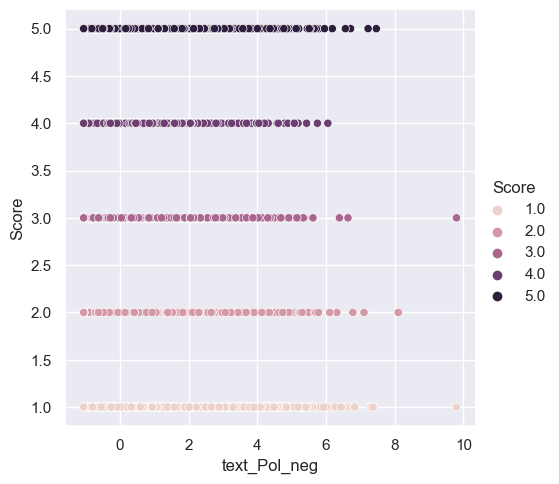

In [400]:
temp = dataset.copy()[:125777]

sns.set_theme(style="darkgrid")
sns.relplot(data=temp, x="text_Pol_neg", y="Score",hue = 'Score')

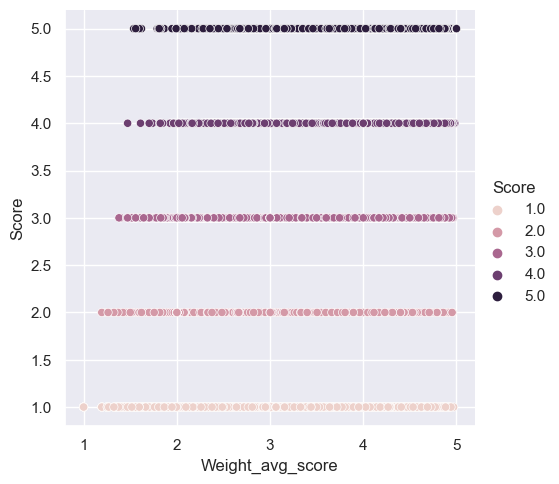

In [75]:
temp = dataset.copy()[:125777]
sns.set_theme(style="darkgrid")
sns.relplot(data=temp, x="Weight_avg_score", y="Score",hue = 'Score')

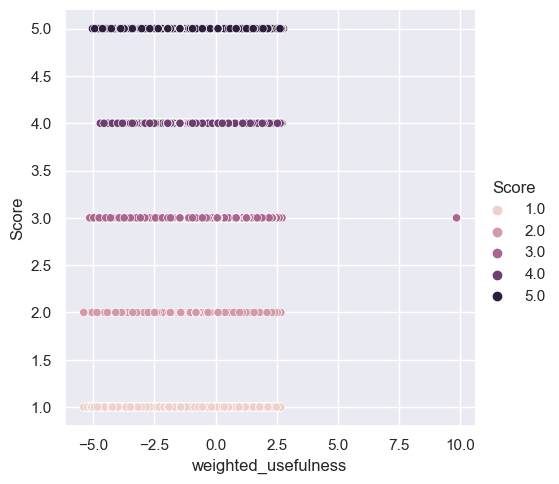

In [714]:
temp = dataset.copy()[:125777]
sns.set_theme(style="darkgrid")
sns.relplot(data=temp, x="weighted_usefulness", y="Score",hue = 'Score')

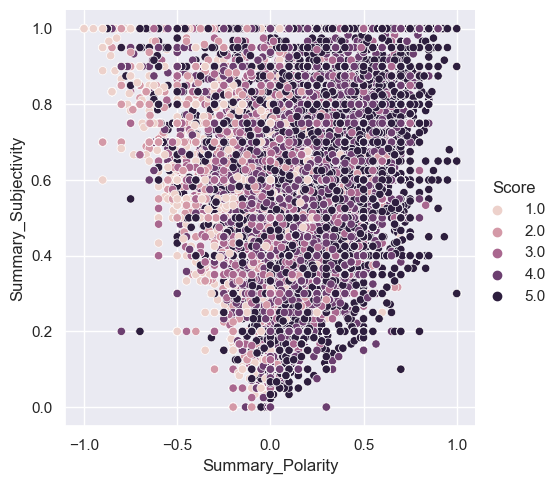

In [871]:
sns.set_theme(style="darkgrid")
sns.relplot(data=temp, x="Summary_Polarity", y="Summary_Subjectivity",hue = 'Score')

In [432]:
midclass_df = df.loc[(df.Score == 2) |(df.Score == 3) |(df.Score == 4)].copy()

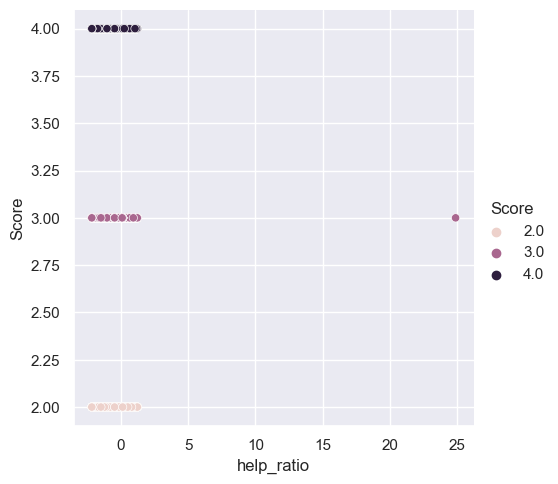

In [451]:
sns.set_theme(style="darkgrid")
sns.relplot(data=midclass_df, x="help_ratio", y="Score", hue = 'Score')

# tfidf

In [570]:
# so I don't need to run dictionary things above
dataset = pd.read_csv("./data/dataset_change.csv")
dataset['Cleanedtext'].loc[dataset['Cleanedtext'].isna()] = ''
dataset['Cleanedsummary'].loc[dataset['Cleanedsummary'].isna()] = ''
dataset['Text'].loc[dataset['Text'].isna()] = ''
dataset['Summary'].loc[dataset['Summary'].isna()] = ''

/var/folders/jc/ytj5cn2153v5xcrd3vd8mj600000gn/T/ipykernel_17805/315487118.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Cleanedtext'].loc[dataset['Cleanedtext'].isna()] = ''
/var/folders/jc/ytj5cn2153v5xcrd3vd8mj600000gn/T/ipykernel_17805/315487118.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Cleanedsummary'].loc[dataset['Cleanedsummary'].isna()] = ''
/var/folders/jc/ytj5cn2153v5xcrd3vd8mj600000gn/T/ipykernel_17805/315487118.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

In [571]:
sum_topic_proportions = sparse.load_npz('./data/sum_topic_proportions.npz')
text_topic_proportion = sparse.load_npz('./data/text_topic_proportion.npz')

In [572]:
dataset.columns

Index(['Id', 'ProductId', 'UserId', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Summary', 'Text', 'Score',
       'Weight_avg_score', 'ReviewLength', 'weighted_num',
       'weighted_usefulness', 'weighted_score', 'weighted_review_length',
       'user_avg_score', 'Text_Polarity', 'Text_Subjectivity',
       'Summary_Polarity', 'Summary_Subjectivity', 'Cleanedtext',
       'Cleanedsummary', 'avg_product_score', 'help_ratio', 'adjust_Polarity',
       'ajust_subjective', 'adjust_sumPolarity', 'ajust_sumSubjective',
       'text_Pol_comp', 'text_Pol_neg', 'text_Pol_neu', 'text_Pol_pos',
       'Sum_Pol_comp', 'Sum_Pol_neg', 'Sum_Pol_neu', 'Sum_Pol_pos',
       'uncln_text_Pol_comp', 'uncln_text_Pol_neg', 'uncln_text_Pol_neu',
       'uncln_text_Pol_pos', 'uncln_Sum_Pol_comp', 'uncln_Sum_Pol_neg',
       'uncln_Sum_Pol_neu', 'uncln_Sum_Pol_pos'],
      dtype='object')

In [756]:
from sklearn.preprocessing import StandardScaler
standscaler = StandardScaler()
use_col = ['Weight_avg_score','weighted_usefulness','text_Pol_neg', 'text_Pol_neg','weighted_review_length']
scalerfitter = standscaler.fit(dataset[use_col])
dataset[use_col] = scalerfitter.transform(dataset[use_col])

In [757]:
# df is the dataset with score, so later we can split it into train and test case
df = dataset.dropna(subset=['Score'])

# Merge on Id so that the test set can have feature columns as well
testX = pd.read_csv("./data/test.csv")
submissionSet = pd.merge(dataset, testX, left_on='Id', right_on='Id')
submissionSet = submissionSet.drop(columns=['Score_x'])
submissionSet = submissionSet.rename(columns={'Score_y': 'Score'})

In [575]:
midclass_df = df.loc[(df.Score == 2) |(df.Score == 3) |(df.Score == 4)].copy()
mid_tf_idf = TfidfVectorizer(
    max_df=0.5, # ignoring terms that appear in more than 50% of the documents 
    min_df=5, # terms that are not present in at least 5 documents 
    stop_words="english",
)
mid_Text_tfidf = mid_tf_idf.fit(midclass_df.Cleanedtext) # Text column
mid_Summary_tfidf = mid_tf_idf.fit(midclass_df.Cleanedsummary) # Summary column
# train set
mid_train_Text_matrix = mid_Text_tfidf.transform(midclass_df.Cleanedtext) # Text column
mid_train_Summary_matrix = mid_Summary_tfidf.transform(midclass_df.Cleanedsummary) # Summary column


KeyboardInterrupt: 

In [515]:
mid_col = ['text_Pol_neg','text_Pol_pos']
mid_addon = csr_matrix(midclass_df[use_col].values) #72
mid_matrix = hstack([mid_addon,mid_train_Summary_matrix,mid_train_Text_matrix])

Accuracy on gnb =  0.6843674013648129
RMSE on testing set =  0.41069887834339946


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


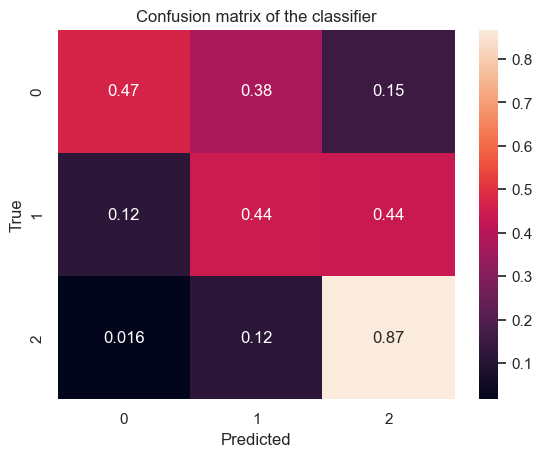

In [495]:

X_train, X_test, Y_train, Y_test = train_test_split(
        mid_matrix, midclass_df['Score'], test_size=.25, random_state=0)
mid_log = LogisticRegression()
gnb_pred = mid_log.fit(X_train, Y_train).predict(X_test)
print("Accuracy on gnb = ", accuracy_score(gnb_pred, Y_test))
print("RMSE on testing set = ", mean_squared_error(Y_test, gnb_pred))
cm = confusion_matrix(Y_test, gnb_pred, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [98]:
tf_idf = TfidfVectorizer(
    max_df=0.5, # ignoring terms that appear in more than 50% of the documents 
    min_df=5, # terms that are not present in at least 5 documents 
    stop_words="english",
)
Text_tfidf = tf_idf.fit(dataset.Cleanedtext) # Text column
Summary_tfidf = tf_idf.fit(dataset.Cleanedsummary) # Summary column

# train set
train_Text_matrix = Text_tfidf.transform(df.Cleanedtext) # Text column
train_Summary_matrix = Summary_tfidf.transform(df.Cleanedsummary) # Summary column
# final testing set
final_test_Text_matrix = Text_tfidf.transform(submissionSet.Cleanedtext) # Text column
final_test_Summary_matrix = Summary_tfidf.transform(submissionSet.Cleanedsummary) # Summary column

train_Text_matrix.shape # return the sample size and the number of features(words)

(125777, 7161)

In [276]:
uncleaned_Text_tfidf = tf_idf.fit(df.Text) # Text column
uncleaned_Summary_tfidf = tf_idf.fit(df.Summary) # Summary column

# train set
train_uncleaned_Text_matrix = uncleaned_Text_tfidf.transform(df.Text) # Text column
train_uncleaned_Summary_matrix = uncleaned_Summary_tfidf.transform(df.Summary) # Summary column
# final testing set
final_test_uncleaned_Text_matrix = uncleaned_Text_tfidf.transform(submissionSet.Text) # Text column
final_test_uncleaned_Summary_matrix = uncleaned_Summary_tfidf.transform(submissionSet.Summary) # Summary column

train_uncleaned_Text_matrix.shape # return the sample size and the number of features(words)

(125777, 7221)

According to https://towardsdatascience.com/working-with-sparse-data-sets-in-pandas-and-sklearn-d26c1cfbe067#:~:text=Sklearn%20and%20other%20machine%20learning,before%20passing%20it%20to%20sklearn. we can convert dataframe into sparse matrix, and process them in the machine learning model. This not enable me to apply the text sparse matrix, but also allow model to run faster

In [758]:
# convert dataframe to sparse matrix https://stackoverflow.com/questions/20459536/convert-pandas-dataframe-to-sparse-numpy-matrix-directly 
# concatenate matrices https://stackoverflow.com/questions/19710602/concatenate-sparse-matrices-in-python-using-scipy-numpy


# turn df with columns to matrix

train_sparse_matrix = csr_matrix(df[use_col].values) #72

final_test_sparse_matrix = csr_matrix(submissionSet[use_col].values)

# concate text and summary matrix
train_sparse_matrix = hstack([train_Text_matrix,train_Summary_matrix,train_sparse_matrix
                              ]) 
#text_topic_proportion[:,125777:].T, sum_topic_proportions[:,125777:].T
final_test_sparse_matrix = hstack([final_test_Text_matrix,final_test_Summary_matrix, final_test_sparse_matrix
                                   ])
#y_test = csr_matrix(Y_test.values)
target = df['Score']
#TODO: Can turn target into sparse matrix

    Start testing

Score function that draw the graph

In [196]:
def score(pred, test):
    for i in range(1,6):
        print(test[test==i].loc[pred != test].count())
        print('proportion: ', (test[test==i].loc[pred != test].count())/test[test==i].count())
    for i in range(1,6):
        print('predict val for ', i)
        plt.bar(range(1,6), [(pred[test==i] == x).sum() for x in range(1,6)], color ='maroon',
            width = 0.4)
        plt.show()

In [759]:
# split test and train set
X_train, X_test, Y_train, Y_test = train_test_split(
        train_sparse_matrix, target, test_size=.25, random_state=40)
from sklearn import preprocessing

Function that test and compare three model accuracy

In [760]:
from sklearn.linear_model import Ridge
clf2 = Ridge(alpha=7)
clf2.fit(X_train, Y_train)
result = clf2.predict(X_test)

In [764]:
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
print(accuracy_score(result, Y_test))
print("RMSE on testing set = ", mean_squared_error(result, Y_test))

0.5873429798060105
RMSE on testing set =  0.5785657497217364


In [761]:
result = result.round()
result

array([5., 4., 5., ..., 3., 4., 2.])

In [762]:
result[result < 1] = 1
result[result > 5] = 5

In [459]:
gnb = MultinomialNB()
gnb_pred = gnb.fit(X_train, Y_train).predict(X_test)
print("Accuracy on gnb = ", accuracy_score(gnb_pred, Y_test))
print("RMSE on testing set = ", mean_squared_error(Y_test, gnb_pred))

Accuracy on gnb =  0.6020352997296867
RMSE on testing set =  1.2272539354428367


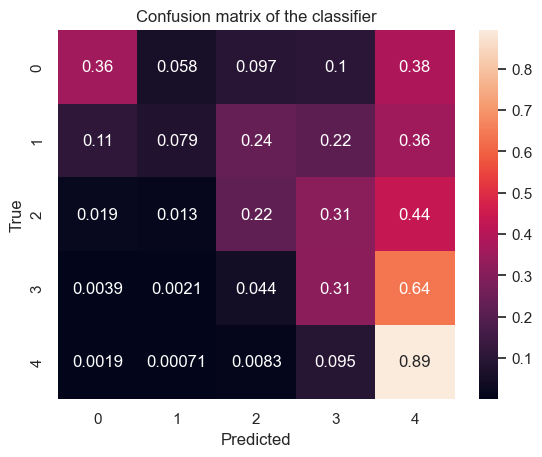

In [460]:
cm = confusion_matrix(Y_test, gnb_pred, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [203]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
def best(xtrain,xtest,ytrain,ytest,run_gnb = True):
    if(run_gnb):
        gnb = MultinomialNB()
        gnb_pred = gnb.fit(xtrain, ytrain).predict(xtest)
        print("Accuracy on gnb = ", accuracy_score(gnb_pred, ytest))
        print("RMSE on testing set = ", mean_squared_error(ytest, gnb_pred))
    lm = LogisticRegression()
    lm.fit(xtrain,ytrain)
    pred = lm.predict(xtest)
    print("Accuracy on loR = ", accuracy_score(pred, ytest))
    print("RMSE on testing set = ", mean_squared_error(ytest, pred))
    
    rfc = RandomForestClassifier(10)
    rfc.fit(xtrain[:5000], ytrain[:5000])
    pre = rfc.predict(xtest)
    print("Accuracy on rfc = ", accuracy_score(pre, ytest))
    print("RMSE on testing set = ", mean_squared_error(ytest, pre))
    
    # knn = KNeighborsClassifier(n_neighbors=100)
    # knn.fit(xtrain[:2500], ytrain[:2500])
    # print("Accuracy on knn = ", accuracy_score(knn.predict(xtest), ytest))
    

In [505]:
best(X_train,X_test,Y_train,Y_test,False)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy on loR =  0.6316107489266974
RMSE on testing set =  0.9399904595325171
Accuracy on rfc =  0.5353792335824455
RMSE on testing set =  1.8356177452695182


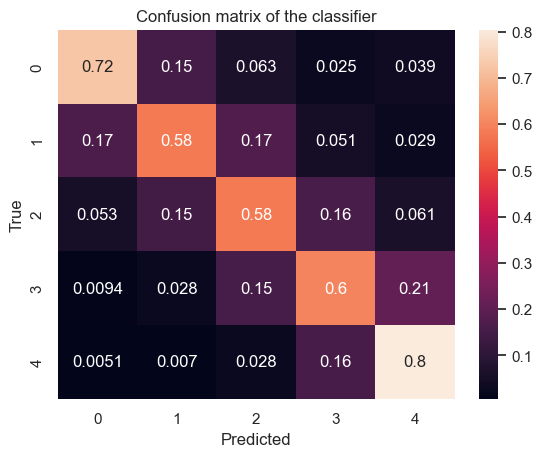

In [569]:
cm = confusion_matrix(bestmodel.predict(X_test), Y_test, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

753
proportion:  0.3915756630265211
1202
proportion:  0.6400425985090522
2135
proportion:  0.5740790535090078
3973
proportion:  0.5587904360056258
1557
proportion:  0.09259589652096342
predict val for  1


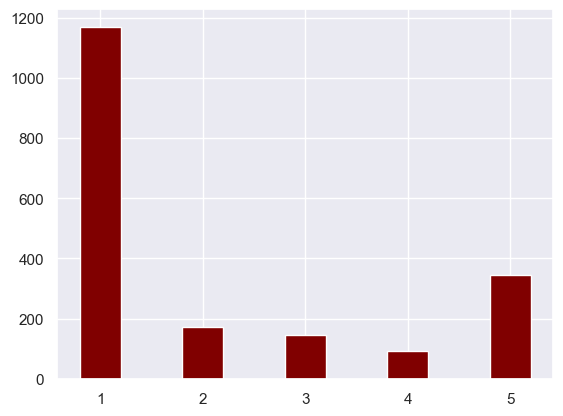

predict val for  2


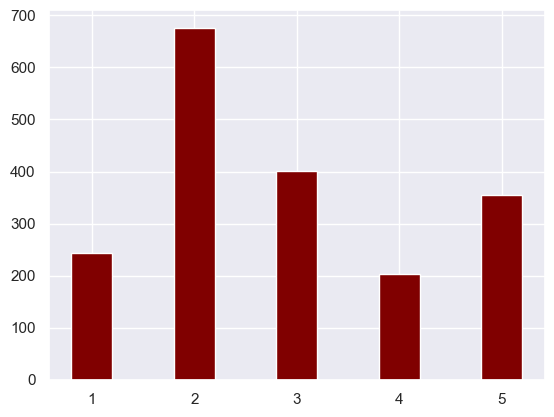

predict val for  3


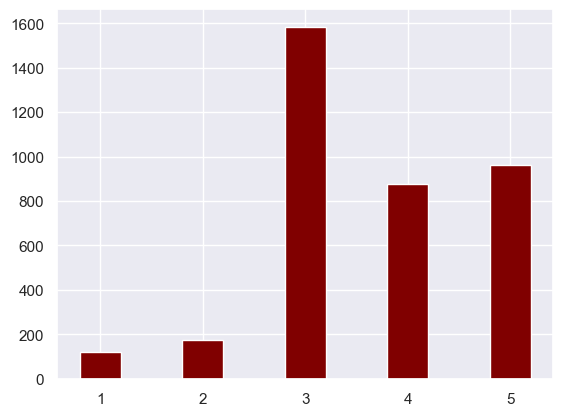

predict val for  4


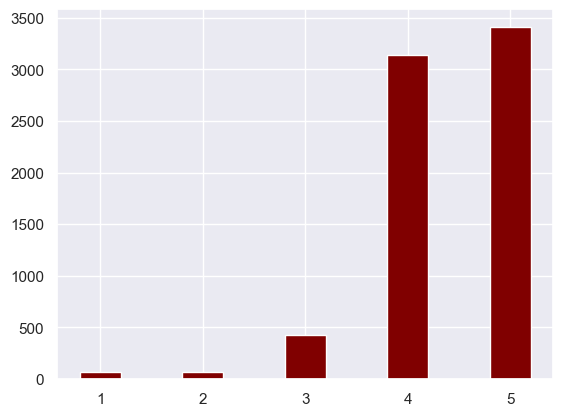

predict val for  5


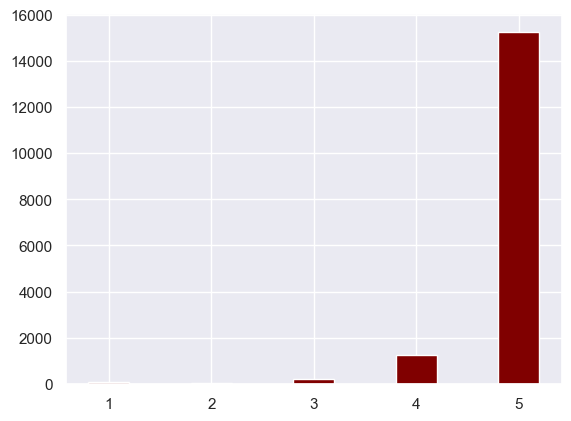

In [512]:
score(bestmodel.predict(X_test),Y_test)

Try combine three different classifiers using voting classifer

In [709]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

def fit_multiple_estimators(classifiers, X_list, y, sample_weights = None):

    # Convert the labels `y` using LabelEncoder, because the predict method is using index-based pointers
    # which will be converted back to original data later.
    le_ = LabelEncoder()
    le_.fit(y)
    transformed_y = le_.transform(y)

    # Fit all estimators with their respective feature arrays
    estimators_ = [clf.fit(X, y) if sample_weights is None else clf.fit(X, y, sample_weights) for clf, X in zip([clf for _, clf in classifiers], X_list)]

    return estimators_, le_


def predict_from_multiple_estimator(estimators, label_encoder, X_list, weights = None):

    # Predict 'soft' voting with probabilities

    pred1 = np.asarray([clf.predict_proba(X) for clf, X in zip(estimators, X_list)])
    pred2 = np.average(pred1, axis=0, weights=weights)
    pred = np.argmax(pred2, axis=1)

    # Convert integer predictions to original labels:
    return label_encoder.inverse_transform(pred)

In [711]:
logR_matrix = csr_matrix(df[use_col].values)
clf1 = Ridge(alpha=7)
clf2 = MultinomialNB()

logR_matrix = csr_matrix(df[use_col].values)
train_matrix = hstack([train_Text_matrix,train_Summary_matrix,text_topic_proportion.T[:125777], sum_topic_proportions.T[:125777]
                    ]) 

y_train = df.Score[:94332]
y_test = df.Score[94332:]
X_train_list = [train_matrix[:94332], logR_matrix[:94332]]
X_test_list = [train_matrix[94332:], logR_matrix[94332:]]
classifiers = [('gnb',  MultinomialNB()),
    ('r', Ridge(alpha=7))]

In [712]:
fitted_estimators, label_encoder = fit_multiple_estimators(classifiers, X_train_list, y_train)
y_pred = predict_from_multiple_estimator(fitted_estimators, label_encoder, X_test_list)
print(accuracy_score(y_test, y_pred))
print("RMSE on testing set = ", mean_squared_error(y_test, y_pred))

AttributeError: 'Ridge' object has no attribute 'predict_proba'

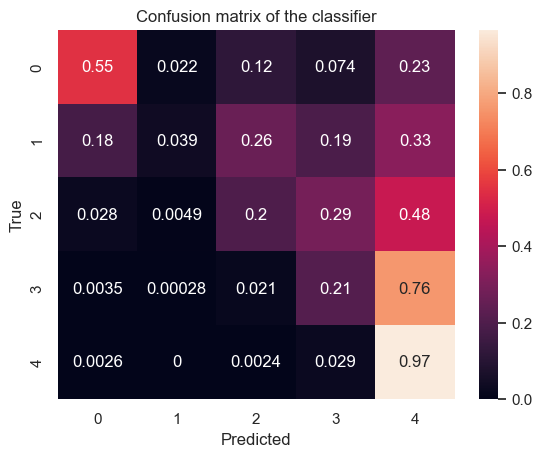

In [431]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [365]:
from sklearn.ensemble import VotingClassifier


clf1 = LogisticRegression(random_state=1).fit(logR_matrix, ytrain).predict()
clf2 = RandomForestClassifier(random_state=1)


X_train_gnb = train_matrix[:94332]
X_test_gnb = train_matrix[94332:]


eclf = VotingClassifier(
    estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)],
    voting='soft'
)

# clf1.fit(X_train, Y_train)
# p = clf1.predict(X_test)
# print("Accuracy on 1 = ", accuracy_score(p, Y_test))
# print("RMSE on testing set = ", mean_squared_error(p, Y_test))
# clf2.fit(X_train, Y_train)
# p = clf2.predict(X_test)
# print("Accuracy on 2 = ", accuracy_score(p, Y_test))
# print("RMSE on testing set = ", mean_squared_error(p, Y_test))
# eclf.fit(X_train, Y_train)
p = eclf.predict(xtest)
print("Accuracy on 4 = ", accuracy_score(p, ytest))
print("RMSE on testing set = ", mean_squared_error(p, ytest))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy on 1 =  0.6703450469072985
RMSE on testing set =  0.643472730163778
Accuracy on 2 =  0.5987915407854985
RMSE on testing set =  1.3788519637462235


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy on 4 =  0.6699316266497058
RMSE on testing set =  0.7328987120368898


In [ ]:
from sklearn.ensemble import VotingClassifier
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = MultinomialNB()
eclf = VotingClassifier(
    estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)],
    voting='soft'
)
clf1.fit(X_train, Y_train)
print("Accuracy on 1 = ", accuracy_score(clf1.predict(X_test), Y_test))
clf2.fit(X_train, Y_train)
print("Accuracy on 2 = ", accuracy_score(clf2.predict(X_test), Y_test))
clf3.fit(X_train, Y_train)
print("Accuracy on 3 = ", accuracy_score(clf3.predict(X_test), Y_test))
eclf.fit(X_train, Y_train)
print("Accuracy on 4 = ", accuracy_score(eclf.predict(X_test), Y_test))

# params = {'lr__C': [1.0, 100.0], 'rf__n_estimators': [20, 200]}

# grid = GridSearchCV(estimator=eclf, param_grid=params, cv=5)
# grid = grid.fit(X_train, Y_train)
# print("Accuracy on grid = ", accuracy_score(grid.predict(X_test), Y_test))

In [ ]:

def res():
    eclf = VotingClassifier(
        estimators=[('lr', LogisticRegression(random_state=1)), ('rf', RandomForestClassifier(random_state=1)), ('gnb', MultinomialNB())],
        voting='soft'
    )
    #assign 1 and 5
    train_sparse_matrix = csr_matrix(df[['adjust_sumPolarity','ajust_sumSubjective','help_ratio',
                                         'adjust_Polarity','ajust_subjective','Weight_avg_score','user_avg_score']].values)
    train_sparse_matrix = hstack([train_Text_matrix,train_Summary_matrix,train_sparse_matrix
                                  ]) 
    temp = eclf.fit(train_sparse_matrix[:100000],df.Score[:100000]).predict(train_sparse_matrix[100000:])
    #assign 2,3,4
    train_sparse_matrix = csr_matrix(df[['adjust_sumPolarity','ajust_sumSubjective','help_ratio',
                                     'adjust_Polarity','ajust_subjective','Weight_avg_score','user_avg_score']].values)
    temp2 = eclf.fit(train_sparse_matrix[:100000],df.Score[:100000]).predict(train_sparse_matrix[100000:])
    data = {'Score': temp,
        'Score2': temp2}
    dd = pd.DataFrame(data)
    dd['Score'] = np.where(
        (dd['Score'] != 5) & (dd['Score'] != 1) , dd.Score2, dd['Score']
        )
    print("Accuracy = ", accuracy_score(dd.Score, df.Score[100000:]))
res()


What if i feed the result of one model into another?

In [ ]:
def feed(firstModel, secModel, x, y , xtrain, ytrain,xtest,ytest):
    firstModel.fit(x,ytrain)
    firstPred = firstModel.predict(xtest)
    xtrain['newpred'] = firstPred
    secModel.fit(xtrain,xtrain)
    secPred = secModel.predict(xtest)
    print("Accuracy on gnb = ", accuracy_score(secPred, ytest))

In [ ]:
feed(lr, gnb,X_train)

What if weighted predict result?

In [708]:
pred1 = lr.predict(xtest,ytest)
pred2 = lr.fit(x,y).predict(xtest,ytest)
wp = pred1*0.5+pred2*0.5
wp

NameError: name 'lr' is not defined

What if three clusters first

1135
proportion:  0.5902236089443578
1200
proportion:  0.6389776357827476
2225
proportion:  0.598279107286905
3462
proportion:  0.4869198312236287
2284
proportion:  0.135831103181683
predict val for  1


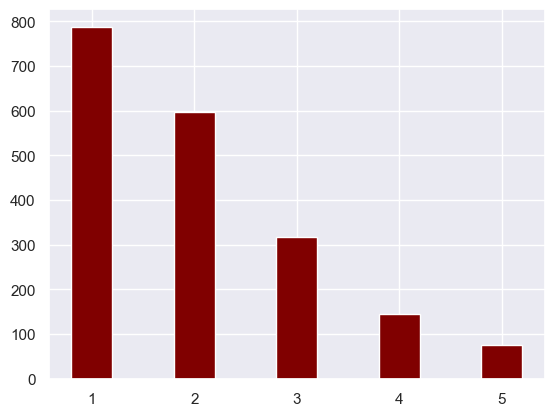

predict val for  2


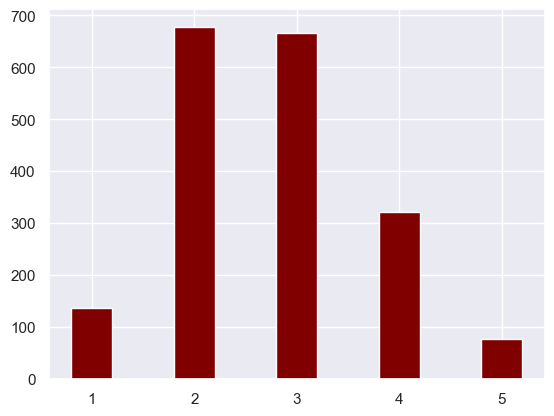

predict val for  3


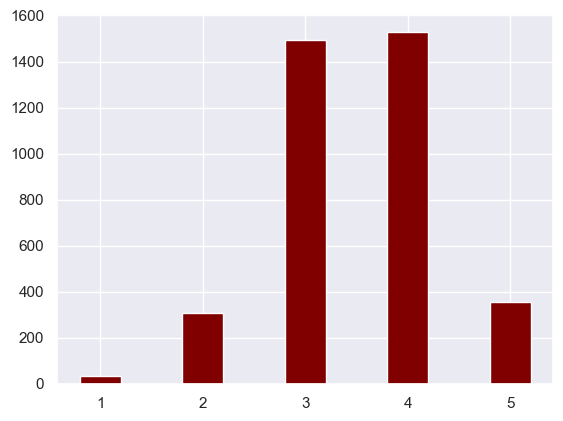

predict val for  4


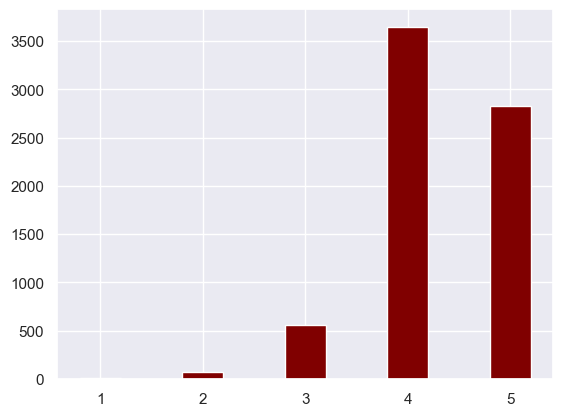

predict val for  5


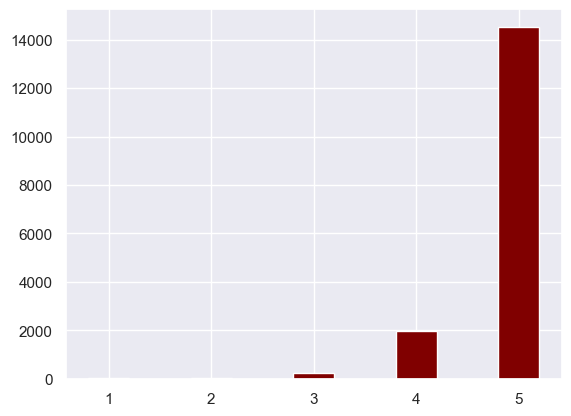

In [379]:
score(temp.values,Y_test)

In [378]:

# let cluster be 1 2-4 and 5
def seperate(X_train,X_test,Y_train):
    temp = Y_train.reset_index(drop=True)
    temp_train = temp.copy()

    temp_mid = temp_train.loc[(temp_train == 2) |(temp_train == 3) |(temp_train == 4)].copy()
    X_train_mid = X_train[temp_mid.index].copy()
    Y_train_mid = temp_train[temp_mid.index].copy()

    temp_train = np.where(
            (Y_train != 5) & (Y_train != 1) , 3 , Y_train
            )
    lm = eclf.fit(X_train, temp_train)
    pred = lm.predict(X_test) #pred contain 1 3 5
    # filter out 3 and keep predict
    pred = pd.Series(pred, copy=False)

    pred_mid_test = pred.loc[pred == 3]
    # Second train
    lm = eclf.fit(X_train_mid, Y_train_mid)
    xtest_temp =  X_test[pred_mid_test.index]
    pred_mid = lm.predict(xtest_temp)
    pred[pred_mid_test.index] = pred_mid
    return pred
temp = seperate(X_train,X_test,Y_train)
print("Accuracy on gnb = ", accuracy_score(temp, Y_test))
print("RMSE on testing set = ", mean_squared_error(y_test, y_pred))

KeyboardInterrupt: 

In [563]:
temp = df['Score'].reset_index(drop=True)
temp_train = temp.copy()

temp_mid = temp_train.loc[(temp_train == 2) |(temp_train == 3) |(temp_train == 4)].copy()
X_train_mid = df.iloc[temp_mid.index].copy()
Y_train_mid = df.iloc[temp_mid.index]['Score'].copy()

temp_train = np.where(
        (temp_train != 5) & (temp_train != 1) , 3 , temp_train
        )
bestmodel, accuracybest = CVKFold(20, train_sparse_matrix, temp_train, model)
#lm = LogisticRegression().fit(X_train, temp_train)
pred = bestmodel.predict(final_test_sparse_matrix) #pred contain 1 3 5
# filter out 3 and keep predict
pred = pd.Series(pred, copy=False)

pred_mid_test = pred.loc[pred == 3]
# Second train



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Sccuracy: 0.9228812211798378


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Sccuracy: 0.8936237875655907


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Sccuracy: 0.9642232469391


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Sccuracy: 0.9521386547940849


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Sccuracy: 0.9031642550484974


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Sccuracy: 0.9286055016695818


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Sccuracy: 0.9387820003180156


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Sccuracy: 0.9317856574972173


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Sccuracy: 0.8853553824137382


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Sccuracy: 0.9336937509937987


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Sccuracy: 0.9317856574972173


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Sccuracy: 0.924153283510892


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Sccuracy: 0.9515026236285578


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Sccuracy: 0.9597710287804102


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Sccuracy: 0.9515026236285578


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Sccuracy: 0.9152488471935125


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Sccuracy: 0.8993480680553347


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Sccuracy: 0.9007633587786259


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Sccuracy: 0.938295165394402
Sccuracy: 0.8804071246819338
Highest accuracy is: 0.8804071246819338


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [519]:
mid_X_train, mid_X_test, mid_Y_train, mid_Y_test = train_test_split(
        mid_matrix, midclass_df['Score'], test_size=.25, random_state=0)
mid_log = LogisticRegression()
mid_log = mid_log.fit(mid_X_train, mid_Y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [564]:
mid_col = ['text_Pol_neg','text_Pol_pos']
fin_mid_addon = csr_matrix(submissionSet[use_col].values) #72
fmid_train_Text_matrix = mid_Text_tfidf.transform(submissionSet.Cleanedtext) # Text column
fmid_train_Summary_matrix = mid_Summary_tfidf.transform(submissionSet.Cleanedsummary) # Summary column
fin_mid_matrix = hstack([fin_mid_addon,fmid_train_Text_matrix,fmid_train_Summary_matrix])

In [565]:
xtest_temp =  fin_mid_matrix[pred_mid_test.index]
pred_mid = mid_log.predict(xtest_temp)
pred[pred_mid_test.index] = pred_mid

Try SVC

In [ ]:
svm = SVC()
param_grid = [
  #{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
grid_search = GridSearchCV(svm, param_grid, cv=5)
grid_search.fit(X_train[:2000], Y_train[:2000])
best_params = grid_search.best_params_

svm = SVC(kernel=best_params['kernel'], C=best_params['C'], gamma=best_params['gamma'])
svm.fit(X_train[:2500], Y_train[:2500])
score = svm.score(X_test, Y_test)
print("Test set score: {:.2f}".format(score))

Kmean (not working)
- kmeans = KMeans(n_clusters=5, random_state=0, n_init='k-means++').fit(X_train[:2500])
- scores = cross_val_score(kmeans, X_test, Y_test, cv=5, scoring='accuracy')

DBC

In [ ]:
# from sklearn.cluster import DBSCAN
# eps_l = [.1,.2,.3,.5,.7]
# for i in eps_l:
#     dbc = DBSCAN(eps = i, min_samples = 10)   # eps=0.1
#     km.fit(X_train,Y_train)        
    
#     print("Accuracy on testing set = ", accuracy_score(km.labels_, Y_test_label))


Try Knn classifier

In [ ]:
# # neigh = [100,500,1000] # run and find 100 is the best

# knn = KNeighborsClassifier(n_neighbors = 100)
# knn.fit(X_train[:2500], Y_train[:2500])
# #y_pred = knn.predict(X_test)
# scores = cross_val_score(knn, X_test, Y_test, cv=5, scoring='accuracy')
# print(np.mean(scores))

Submission

In [561]:
len(pred.values)

13976

In [765]:
# submissionSet['Score'] = temp.values
clf2 = Ridge(alpha=7)
clf2.fit(train_sparse_matrix, target)
result = clf2.predict(final_test_sparse_matrix)

In [766]:
result = result.round()

In [768]:
result.min()

1.0

In [767]:
result[result < 1] = 1
result[result > 5] = 5

In [769]:

# make prediction and store in Score column

# model = elf.fit(train_sparse_matrix, target)
# submissionSet['Score'] = model.predict(final_test_sparse_matrix)

# temp = seperate(train_sparse_matrix,final_test_sparse_matrix,target)


submissionSet['Score'] = result

#Actual submission file
submission = submissionSet[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)